In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np
import pandas as pd
import pathlib
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
import time
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 600)
pd.options.display.float_format = "{:.4f}".format
plt.style.use("ggplot")
plt.rcParams["font.size"] = 13

In [ ]:
# value生成
def generate_item_values(sample_size, num_bidders, num_items, val_model, seeds=123456789):
    if val_model=="uniform_0_1":
        data = tf.random.uniform(shape=[sample_size,num_bidders,num_items],minval=0,maxval=1,dtype=tf.dtypes.float32,seed=seeds)

    #Unif(0,1)以外は必要に応じ追加
    else:
        raise NotImplementedError(f"Model: {val_model} is not defined.")

    return data

def generate_data(sample_size, num_bidders, num_items, val_model, num_batch, seeds=123456789):
    if val_model=="uniform_0_1":
        data = generate_item_values(sample_size, num_bidders, num_items, val_model)
        return [tf.Variable(batch,constraint=lambda x: tf.clip_by_value(x, clip_value_max=1.0, clip_value_min=0.0)) for batch in tf.unstack(tf.split(data, num_or_size_splits=num_batch, axis= 0))]
    else:
        raise NotImplementedError(f"Model: {val_model} is not defined.")

In [ ]:
# model
def generate_model(num_bidders, num_items, num_alloc_cells, num_pay_cells,random_seed=20220917, utility="additive"):
    tf.random.set_seed(seed=random_seed)

    # input layer
    input_layer = keras.layers.Input(shape=(num_bidders,num_items,))
    flatten_layer =  keras.layers.Flatten()(input_layer)

    # allocation network
    alloc_hidden_layer_0 = keras.layers.Dense(num_alloc_cells, activation='tanh')(flatten_layer)
    alloc_hidden_layer_1 = keras.layers.Dense(num_alloc_cells, activation='tanh')(alloc_hidden_layer_0)
    alloc_hidden_layer_2 = keras.layers.Dense(num_alloc_cells, activation='tanh')(alloc_hidden_layer_1)
    alloc_hidden_layer_3 = keras.layers.Dense((num_bidders+1)*num_items, activation='linear')(alloc_hidden_layer_2) # num_bidders + 1 : bidders + nobody gets the item
    alloc_reshape_1 = keras.layers.Reshape((num_bidders+1,num_items))(alloc_hidden_layer_3)

    alloc_output_1 = keras.layers.Lambda(
        lambda s: tf.nn.softmax(s, axis=1,), # itemごとにsoftmax
        output_shape=(num_bidders+1, num_items)
    )(alloc_reshape_1)
    alloc_output_2 = keras.layers.Lambda(
        lambda t: t[:,:-1], # 誰にも与えない選択肢の確率を落とす
        output_shape=(num_bidders, num_items)
    )(alloc_output_1)

    # payment network
    pay_hidden_layer_0 = keras.layers.Dense(num_pay_cells, activation='tanh')(flatten_layer)
    pay_hidden_layer_1 = keras.layers.Dense(num_pay_cells, activation='tanh')(pay_hidden_layer_0)
    pay_hidden_layer_2 = keras.layers.Dense(num_pay_cells, activation='tanh')(pay_hidden_layer_1)

    pay_output = keras.layers.Dense(num_bidders, activation='sigmoid')(pay_hidden_layer_2) # payment networkのoutput

    # allocationとpaymentを合わせ支払額を算出
    alloc_bid = keras.layers.Multiply()([alloc_output_2,input_layer]) # allocation*bid
    alloc_bid_sum = keras.layers.Lambda(
        lambda s: tf.reduce_sum(s,axis=-1),
        output_shape=(num_bidders, )
    )(alloc_bid) # 各bidderのallocation*bidの計

    pay = keras.layers.Multiply()([alloc_bid_sum, pay_output]) # payment*sum(allocation*bid) = (各bidderの支払額)

    model = keras.Model(inputs=input_layer, outputs=[alloc_output_2, pay])
    model.summary()

    return model

In [ ]:
class Trainer(object):
    def __init__(self, model, num_bidders, num_items, val_model):
        self.model = model
        self.num_bidders = num_bidders
        self.num_items = num_items
        self.val_model = val_model

    #支払合計を計算
    @tf.function
    def _compute_rev(self, val):
        _, pay = self.model(tf.expand_dims(val, axis=0))
        return tf.reduce_sum(pay)

    #regretを計算
    @tf.function
    def _compute_mis_util(self, val, mis):
        true_val = tf.tile(val, [self.num_bidders, 1, 1])
        true_val_r = tf.reshape(true_val, [self.num_bidders, self.batch_size, self.num_bidders, self.num_items])

        adv = tf.tile(tf.expand_dims(mis, 0), [self.num_bidders, 1, 1, 1])
        misrep = tf.reshape(true_val_r * (1 - self.adv_mask) + adv * self.adv_mask, [-1, self.num_bidders, self.num_items])

        m_alloc,m_pay = self.model(misrep)
        m_util = tf.reduce_sum(tf.multiply(m_alloc, true_val), axis=-1) - m_pay
        m_util_r = tf.reshape(m_util, [self.num_bidders,self.batch_size,self.num_bidders]) * self.u_mask
        return m_util_r

    @tf.function
    def _compute_reg(self, val, mis):
        true_val = tf.tile(val, [self.num_bidders, 1, 1])
        true_val_r = tf.reshape(true_val, [self.num_bidders, self.batch_size, self.num_bidders, self.num_items])

        adv = tf.tile(tf.expand_dims(mis, 0), [self.num_bidders, 1, 1, 1])
        misrep = tf.reshape(true_val_r * (1 - self.adv_mask) + adv * self.adv_mask, [-1, self.num_bidders, self.num_items])

        m_alloc,m_pay = self.model(misrep)
        m_util = tf.reduce_sum(tf.multiply(m_alloc, true_val), axis=-1) - m_pay
        m_util_r = tf.reshape(m_util, [self.num_bidders,self.batch_size,self.num_bidders]) * self.u_mask

        t_alloc,t_pay = self.model(val)
        t_util = tf.reduce_sum(tf.multiply(t_alloc, val), axis=-1) - t_pay
        t_util_r = tf.reshape(tf.tile(t_util, [self.num_bidders, 1]), [self.num_bidders, self.batch_size, self.num_bidders])

        excess_from_utility = tf.nn.relu(tf.reshape(m_util_r - t_util_r, [self.num_bidders,self.batch_size,self.num_bidders]) * self.u_mask)
        regret = tf.reduce_mean(tf.reduce_max(excess_from_utility, axis=(2,)),axis = (1))
        return regret

    #Training
    @tf.function
    def _main_train_step(self, batch, batch_misreports):
        with tf.GradientTape() as tape:
            tape.watch(self.model.trainable_weights)
            # Lossを計算
            rev = tf.reduce_mean(tf.map_fn(fn=lambda v:self._compute_rev(v), elems = batch))
            regret = self._compute_reg(batch, batch_misreports)
            regret1 = tf.reduce_sum(tf.multiply(regret,self.lagrange_multiplier))
            regret2 = tf.reduce_sum(tf.multiply(regret,regret))*self.update_rate/2
            loss = -rev + regret1 + regret2
        grads_main = tape.gradient(loss,self.model.trainable_weights)
        self.main_opt.apply_gradients(zip(grads_main,self.model.trainable_weights))

    @tf.function
    def _lagr_train_step(self, batch, batch_misreports):
        with tf.GradientTape() as tape:
            tape.watch(self.lagrange_multiplier)
            regret = self._compute_reg(batch, batch_misreports)
            lag_loss = -tf.reduce_sum(tf.multiply(regret,self.lagrange_multiplier))
        grads_lagr = tape.gradient(lag_loss,self.lagrange_multiplier)
        self.lagr_opt.apply_gradients(zip([grads_lagr],[self.lagrange_multiplier]))

    @tf.function
    def _mis_train_step(self, batch, batch_misreports):
        with tf.GradientTape() as tape:
            tape.watch(batch_misreports)
            mis_util = -tf.reduce_sum(self._compute_mis_util(batch, batch_misreports))
        grads_mis=tape.gradient(mis_util, batch_misreports)
        self.mis_opt.apply_gradients(zip([grads_mis],[batch_misreports]))

    def _train_batch(self, batch, batch_misreports):
        # misreportsを最適化
        for _ in range(self.mis_iter):
            #misreportsを更新
            self._mis_train_step(batch, batch_misreports)

        self.misreports[self.iter%self.num_batch] = batch_misreports

        # NNを更新
        self._main_train_step(batch,batch_misreports)

        # Lagrange係数を更新
        if self.iter%self.lagr_multi_iter == 0 and self.iter != 0:
            self._lagr_train_step(batch,batch_misreports)
        # update_rateを更新
        if self.iter%self.update_rate_iter == 0 and self.iter != 0:
            self.update_rate += self.update_rate_inclement
            self.lagr_opt.lr.assign(self.update_rate)

    @tf.function
    def _test_compute_mis_util(self, test_batch_size, num_misreports, batch, batch_misreports, test_adv_mask, test_u_mask):
        true_val = tf.tile(batch, [self.num_bidders*num_misreports, 1, 1])
        true_val_r = tf.reshape(true_val, [self.num_bidders, test_batch_size, num_misreports, self.num_bidders, self.num_items])
        adv = tf.tile(tf.expand_dims(batch_misreports, 0), [self.num_bidders, 1, 1, 1, 1])
        misrep = tf.reshape(true_val_r * (1 - test_adv_mask) + adv * test_adv_mask, [-1, self.num_bidders, self.num_items])
        m_alloc,m_pay = self.model(misrep)
        m_util = tf.reduce_sum(tf.multiply(m_alloc, true_val), axis=-1) - m_pay
        m_util_r = tf.reshape(m_util, [self.num_bidders,test_batch_size,num_misreports,self.num_bidders]) * test_u_mask
        return -tf.reduce_sum(m_util_r)


    def _test_compute_reg(self, test_batch_size, num_misreports, batch, batch_misreports, test_adv_mask, test_u_mask):
        true_val = tf.tile(batch, [self.num_bidders*num_misreports, 1, 1])
        true_val_r = tf.reshape(true_val, [self.num_bidders, test_batch_size, num_misreports, self.num_bidders, self.num_items])
        adv = tf.tile(tf.expand_dims(batch_misreports, 0), [self.num_bidders, 1, 1, 1, 1])
        misrep = tf.reshape(true_val_r * (1 - test_adv_mask) + adv * test_adv_mask, [-1, self.num_bidders, self.num_items])

        m_alloc,m_pay = self.model(misrep)
        m_util = tf.reduce_sum(tf.multiply(m_alloc, true_val), axis=-1) - m_pay
        m_util_r = tf.reshape(m_util, [self.num_bidders,test_batch_size,num_misreports,self.num_bidders]) * test_u_mask

        t_alloc,t_pay = self.model(batch)
        t_util = tf.reduce_sum(tf.multiply(t_alloc, batch), axis=-1) - t_pay
        t_util_r = tf.reshape(tf.tile(t_util, [self.num_bidders*num_misreports, 1]), [self.num_bidders, test_batch_size, num_misreports, self.num_bidders])

        excess_from_utility = tf.nn.relu(tf.reshape(m_util_r - t_util_r, [self.num_bidders,test_batch_size,num_misreports,self.num_bidders]) * test_u_mask)
        return tf.reduce_mean(tf.reduce_mean(tf.reduce_max(excess_from_utility, axis=(2,3)),axis = (1)),axis = 0)

    def _test_mis_step(self, test_batch_size, num_misreports, batch, batch_misreports, test_adv_mask, test_u_mask):
        with tf.GradientTape() as tape:
            tape.watch(batch_misreports)
            mis_util = self._test_compute_mis_util(test_batch_size, num_misreports, batch, batch_misreports, test_adv_mask, test_u_mask)
        grads_mis=tape.gradient(mis_util, batch_misreports)
        self.test_mis_opt.apply_gradients(zip([grads_mis],[batch_misreports]))

    def test(self, test_batch_size, test_sample_size, num_misreports, mis_learning_rate, test_mis_iter):
        start = time.time()
        # データを生成
        check_data = tf.data.Dataset.from_tensor_slices(generate_item_values(test_sample_size, self.num_bidders, self.num_items, self.val_model)).batch(test_batch_size)
        # misreportsを初期化
        check_misreports = [tf.Variable(mr,constraint=lambda x: tf.clip_by_value(x, clip_value_max=1.0, clip_value_min=0.0)) for mr in tf.unstack(tf.split(tf.reshape(generate_item_values(test_sample_size*num_misreports, self.num_bidders, self.num_items, self.val_model),[test_sample_size,num_misreports,self.num_bidders,self.num_items]), num_or_size_splits=int(test_sample_size/test_batch_size), axis= 0))]

        test_adv_mask = np.zeros([self.num_bidders,test_batch_size,num_misreports,self.num_bidders,self.num_items])
        test_adv_mask[np.arange(self.num_bidders), :, :, np.arange(self.num_bidders), :] = 1.0
        test_u_mask = np.zeros([self.num_bidders,test_batch_size,num_misreports,self.num_bidders])
        test_u_mask[np.arange(self.num_bidders), :, :, np.arange(self.num_bidders)] = 1.0
        test_adv_mask = tf.constant(test_adv_mask, dtype=tf.float32)
        test_u_mask = tf.constant(test_u_mask, dtype=tf.float32)

        self.test_mis_opt = keras.optimizers.Adam(learning_rate=mis_learning_rate)
        total_rev = 0
        total_regret = 0
        test_iter = 0
        for batch, batch_misreports in zip(check_data,check_misreports):
            #収入
            rev = tf.reduce_mean(tf.map_fn(fn=lambda v:self._compute_rev(v), elems = batch))
            total_rev += rev

            #Regret
            for _ in range(test_mis_iter):
                self._test_mis_step(test_batch_size, num_misreports, batch, batch_misreports, test_adv_mask, test_u_mask)
            regret = self._test_compute_reg(test_batch_size, num_misreports, batch, batch_misreports, test_adv_mask, test_u_mask)
            total_regret += regret
            test_iter += 1
            print("test_iter:",test_iter)

        print("time:"+str(time.time()-start))
        return total_rev/(test_sample_size/test_batch_size), total_regret/(test_sample_size/test_batch_size)

    #Training時に外から呼び出す関数
    def train(self, sample_size, batch_size, main_learning_rate, mis_learning_rate, update_rate, update_rate_iter, udpdate_rate_inclement, max_epoch, mis_iter, lagr_multi_iter, lagrange_multiplier, ramdom_seed):
        start = time.time()
        self.sample_size = sample_size
        self.batch_size = batch_size
        self.num_batch = int(self.sample_size/self.batch_size)
        self.update_rate = update_rate
        self.mis_learning_rate = mis_learning_rate
        self.update_rate_iter = update_rate_iter
        self.lagr_multi_iter = lagr_multi_iter
        self.mis_iter = mis_iter
        self.update_rate_inclement = udpdate_rate_inclement

        # データを生成
        self.dataset = generate_data(self.sample_size, self.num_bidders, self.num_items, self.val_model, self.num_batch, seeds=random_seed)
        self.misreports = generate_data(self.sample_size, self.num_bidders, self.num_items, self.val_model, self.num_batch, seeds=random_seed)

        #Lagrange関数のパラメータを初期化
        self.lagrange_multiplier = lagrange_multiplier

        #Optimizerを用意
        self.mis_opt = keras.optimizers.Adam(learning_rate=self.mis_learning_rate)
        self.mis_opt = keras.optimizers.Adam(learning_rate=self.mis_learning_rate, clipnorm=0.1)
        self.main_opt = keras.optimizers.Adam(learning_rate=main_learning_rate)
        self.lagr_opt = keras.optimizers.SGD(learning_rate=self.update_rate)

        self.adv_mask = np.zeros([self.num_bidders,self.batch_size,self.num_bidders,self.num_items])
        self.adv_mask[np.arange(self.num_bidders), :, np.arange(self.num_bidders), :] = 1.0
        self.u_mask = np.zeros([self.num_bidders,self.batch_size,self.num_bidders])
        self.u_mask[np.arange(self.num_bidders), :, np.arange(self.num_bidders)] = 1.0
        self.adv_mask = tf.constant(self.adv_mask, dtype=tf.float32)
        self.u_mask = tf.constant(self.u_mask, dtype=tf.float32)

        self.iter = 0

        for i in range(max_epoch):
            perm = np.random.permutation(self.num_batch)

            for j in perm:
                # Train
                self._train_batch(self.dataset[j], self.misreports[j])
                if self.iter%100 == 0:
                    print("iter:",self.iter)
                self.iter += 1

            #モデルを一時保存
            self.model.save("model_tmp.h5",include_optimizer=False)

            print(self.lagrange_multiplier, self.update_rate)
            print("epoch"+str(i)+"end")
            print("time:"+str(time.time()-start))


# テスト

In [ ]:
num_bidders = 2
num_items = 2
num_alloc_cells = 300
num_pay_cells = 300
val_model ="uniform_0_1"
sample_size = 1280
batch_size = 128
max_epoch = 10
random_seed = 20230516
mis_iter = 25
lagr_multi_iter = 100
main_learning_rate = 0.001
mis_learning_rate = 0.1
test_mis_iter = 2000
update_rate_increment = 5.0
update_rate_iter = 10000
test_batch_size = 100
test_sample_size = 10000
test_num_misreports = 1000
lagrange_multiplier = tf.Variable([5.0,5.0])
update_rate = 1.0

In [ ]:
#読み込み
model_2_2 = generate_model(num_bidders, num_items, num_alloc_cells, num_pay_cells,random_seed=2023212, utility="additive")
trainer_2_2 = Trainer(model_2_2, num_bidders, num_items, val_model)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2, 2)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 4)              │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 300)            │          1,500 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 300)            │         90,300 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 300)            │         90,300 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 6)              │          1,806 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 3, 2)           │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 3, 2)           │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 300)            │          1,500 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 2, 2)           │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 300)            │         90,300 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 2, 2)           │              0 │ lambda_1[0][0],        │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 300)            │         90,300 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 2)              │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 2)              │            602 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 2)              │              0 │ lambda_2[0][0],        │
│                           │                        │                │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 366,608 (1.40 MB)

 Trainable params: 366,608 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
trainer_2_2.train(sample_size, batch_size, main_learning_rate, mis_learning_rate, update_rate, update_rate_iter, update_rate_increment, max_epoch, mis_iter, lagr_multi_iter, lagrange_multiplier, random_seed)

ValueError: in user code:

    File "<ipython-input-4-b840e6024876>", line 52, in _main_train_step  *
        tape.watch(self.model.trainable_weights)

    ValueError: Passed in object <KerasVariable shape=(4, 300), dtype=float32, path=dense/kernel> of type 'Variable', not tf.Tensor or tf.Variable or ExtensionType.


In [ ]:
model_2_2.save('model_2_2.h5', include_optimizer=False)

In [ ]:
model_2_2 = keras.models.load_model('model_2_2.h5', compile=False)
trainer_2_2 = Trainer(model_2_2, num_bidders, num_items, val_model)

In [ ]:
rev,reg = trainer_2_2.test(test_batch_size, test_sample_size, test_num_misreports, mis_learning_rate, test_mis_iter)
print(rev,reg)

KeyboardInterrupt: ignored

319/319 [==============================] - 1s 5ms/step


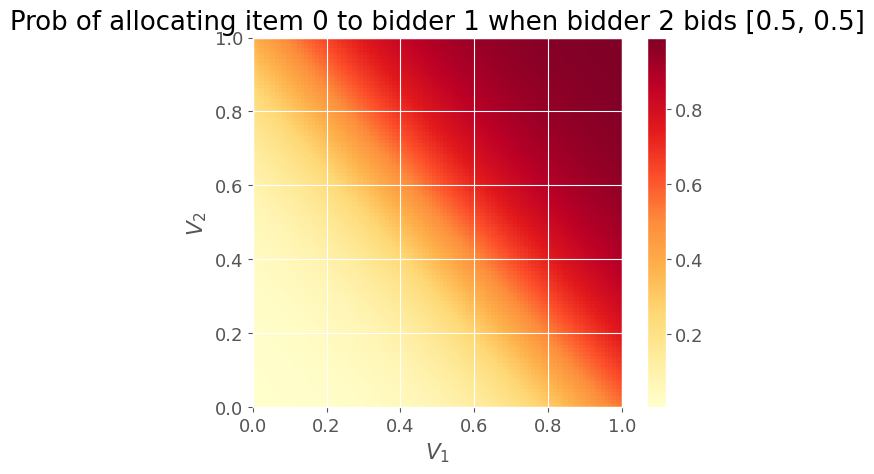

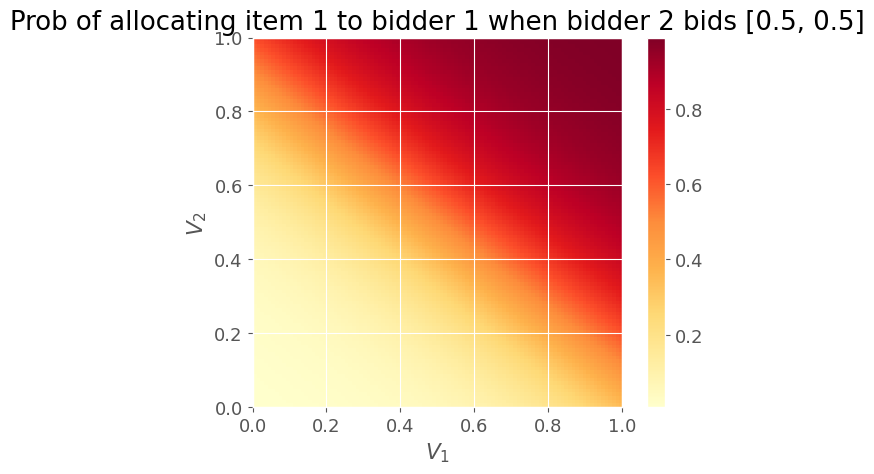

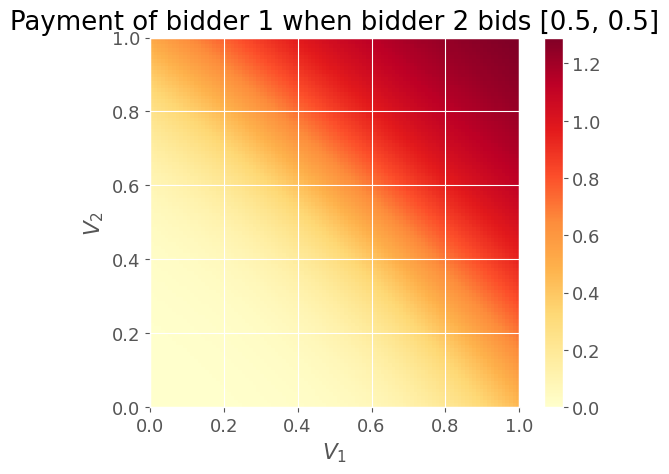

In [ ]:
num_grids = 101
values = np.array(
    np.meshgrid(*[np.linspace(0.0, 1.0, num_grids) for _ in range(num_items)])
).reshape([num_items, num_grids ** num_items]).T

bid2 = [0.5,0.5]

bid2s = np.array([[bid2] for _ in range(num_grids ** num_items)])
X = tf.concat([tf.expand_dims(values,axis=1),bid2s],1)

allocs, payments = model_2_2.predict(X)

for i in range(num_items):
    fig, ax = plt.subplots()
    im = ax.imshow(
        allocs[:,0,i].reshape(*(num_grids for _ in range(num_items)))[::-1,:],
        extent=[0.0, 1.0, 0.0, 1.0],
        cmap="YlOrRd"
    )
    plt.title(f"Prob of allocating item {i} to bidder 1 when bidder 2 bids {bid2}")
    plt.xlabel(f"$V_1$")
    plt.ylabel(r"$V_2$")
    fig.colorbar(im, ax=ax)
    plt.show()

fig, ax = plt.subplots()
im = ax.imshow(
    payments[:, 0].reshape(*(num_grids for _ in range(num_items)))[::-1,:],
    extent=[0.0, 1.0, 0.0, 1.0],
    cmap="YlOrRd"
)
plt.title(f"Payment of bidder 1 when bidder 2 bids {bid2}")
plt.xlabel(f"$V_1$")
plt.ylabel(r"$V_2$")
fig.colorbar(im, ax=ax)
plt.show()

In [ ]:
test_mis_opt = keras.optimizers.Adam(learning_rate=mis_learning_rate)
bidder = 0
bidder_misreport = tf.Variable([0.8,0.8])
value = tf.constant([[0.8,0.8],[0.5,0.5]])
for t in range(250):
    with tf.GradientTape() as tape:
        tape.watch(bidder_misreport)
        mis_bids = trainer_2_2._misrep_insert(bidder_misreport,value, bidder)
        mis_util = -trainer_2_2._compute_utility(value, mis_bids)[0][bidder]
    grads_mis=tape.gradient(mis_util, bidder_misreport)
    bidder_misreport = tf.Variable(tf.clip_by_value(bidder_misreport, clip_value_max=1.0, clip_value_min=0.0,name=None))
    test_mis_opt.apply_gradients(zip([grads_mis],[bidder_misreport]))

print(bidder_misreport)
print(mis_util)

AttributeError: 'Trainer' object has no attribute '_misrep_insert'

In [ ]:
model_2_2.save('drive/My Drive/Colab Notebooks/models/model_2_2_tmp.h5', include_optimizer=False)